# Data Analysis

After our first notebook **data_exploration_overview** , we are about to dig deeper and implement (mainly) more sophisticated approaches to understand and deal with correlation, missing data and outliers 

## 0. Import resources

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [23]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [24]:
df_train = pd.read_csv('data/train.csv')

## 1. Discovery

In [25]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [26]:
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [27]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

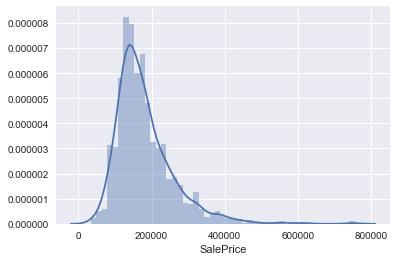

In [28]:
# histogram
sns.distplot(df_train['SalePrice'])

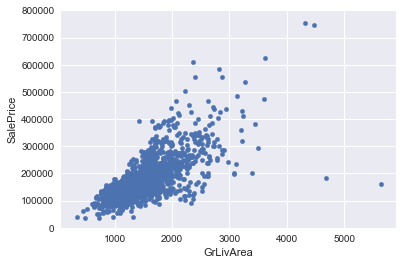

In [29]:
# scatter plot grlivarea/saleprice -linear relationship-
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

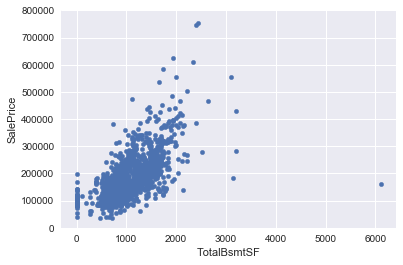

In [30]:
# scatter plot totalbsmtsf/saleprice -exponential relationship?-
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

(-0.5, 9.5, 0, 800000)

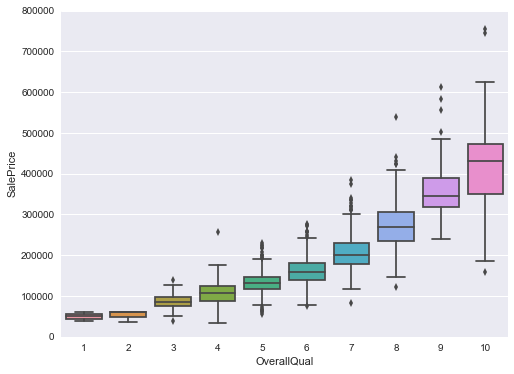

In [31]:
# box plot overallqual/saleprice -Relationship with categorical features-
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

In [32]:
df_train['OverallQual'].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

## 2. More methodically

Until now we just followed our intuition and analysed the variables we thought were important. So, let's do a more objective analysis.

### 2.1 Correlation matrix (heatmap style)

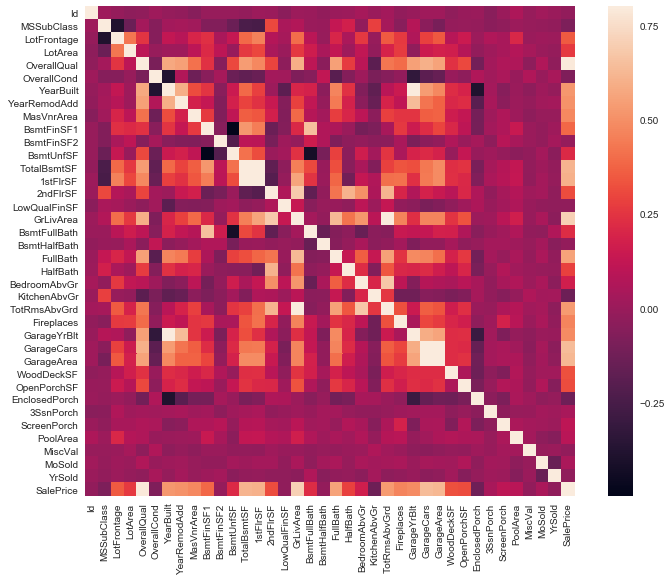

In [33]:
# correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

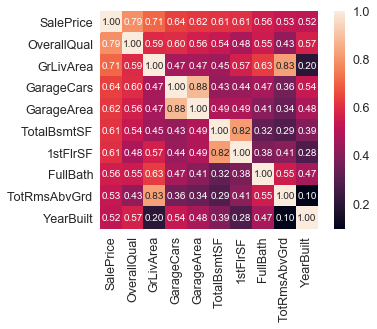

In [34]:
# zoomed heatmap style
# saleprice correlation matrix
num_heat_var = 10 # number of variables for heatmap
cols = corrmat.nlargest(num_heat_var, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- *OverallQual*, *GrLivArea* and *TotalBsmtSF* are strongly correlated with *SalePrice*. Check!

- *GarageCars* and *GarageArea* are also some of the most strongly correlated variables. However, the number of cars that fit into the garage is a consequence of the garage area. *GarageCars* and *GarageArea* are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).

- *TotalBsmtSF* and *1stFloor* also seem to be twin brothers. We will keep *TotalBsmtSF*.

### 2.2. Scatter plots between 'SalePrice' and correlated variables

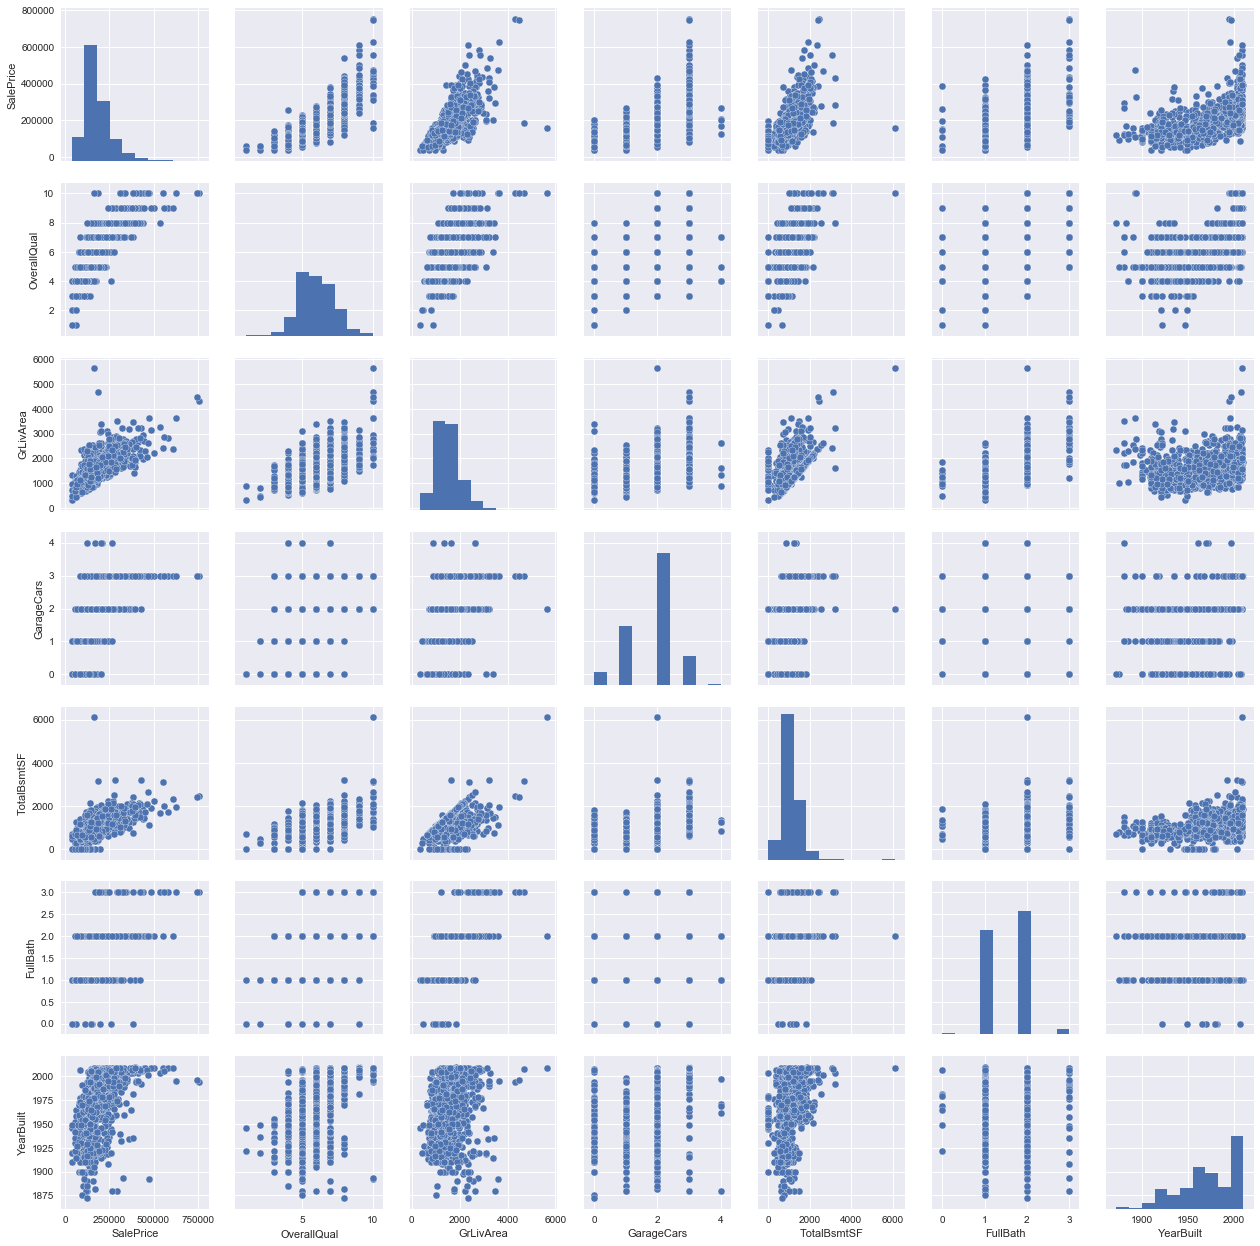

In [35]:
# scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships

### 2.3. Missing data

Important questions when thinking about missing data:

- How prevalent is the missing data?

- Is missing data random or does it have a pattern?

In [36]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. 

According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). 

Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.

In what concerns the remaining cases, we can see that 'GarageX' variables have the same number of missing data. It looks like missing data refers to the same set of observations. Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, We'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In [37]:
# dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# checking that there's no missing data.
df_train.isnull().sum().max()

0

### 2.4. Outliers - Out liars ! ;)

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

#### 2.4.1. Univariate analysis

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [38]:
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


- Low range values are similar and not too far from 0.

- High range values are far from 0 and the 7.something values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.something values.

#### 2.4.2. Bivariate analysis

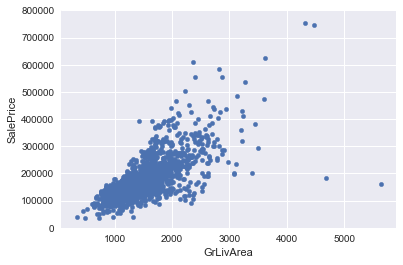

In [39]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

- The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. Not sure about this but it looks like that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.


- The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [40]:
# deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

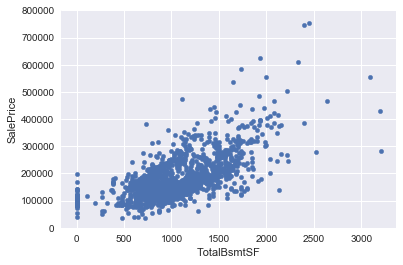

In [41]:
# bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We can feel tempted to eliminate some observations (e.g. TotalBsmtSF > 3000) but I suppose it's not worth it. We can live with that, so we'll not do anything.

###### Special thanks to [Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook)